# DS - Dynamical Systems \& Neural ODEs

**Filled notebook:** 
[![View on Github](https://img.shields.io/static/v1.svg?logo=github&label=Repo&message=View%20On%20Github&color=lightgrey)](https://github.com/phlippe/uvadlc_notebooks/blob/master/docs/tutorial_notebooks/DL2/Dynamical_systems/dynamical_systems_neural_odes.ipynb)
[![Open In Collab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/phlippe/uvadlc_notebooks/blob/master/docs/tutorial_notebooks/DL2/Dynamical_systems/dynamical_systems_neural_odes.ipynb)  
**Empty notebook:** 
[![View on Github Unanswered](https://img.shields.io/static/v1.svg?logo=github&label=Repo&message=View%20On%20Github&color=lightgrey)](https://github.com/phlippe/uvadlc_notebooks/blob/master/docs/tutorial_notebooks/DL2/Dynamical_systems/dynamical_systems_neural_odes_unsolved.ipynb)
[![Open In Collab Unanswered](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/phlippe/uvadlc_notebooks/blob/master/docs/tutorial_notebooks/DL2/Dynamical_systems/dynamical_systems_neural_odes_unsolved.ipynb)  
**Authors:** Riccardo Valperga (Part 1) & Miltos Kofinas (Part 2)

## 0. Introduction

This is a tutorial on dynamical systems, Ordinary Differential Equations (ODEs) 
and numerical solvers, and Neural Ordinary Differential Equations (Neural ODEs).

Below, we import our standard libraries. In this tutorial, we will use [PyTorch Lightning](https://www.pytorchlightning.ai/). Additionally, we will use the ODE solvers from [Torchdiffeq](https://github.com/rtqichen/torchdiffeq). You don't need to use GPUs for this tutorial, you can run the entire codebase in a CPU.

In [1]:
%matplotlib inline
import time
import logging
import statistics
from typing import Optional, List

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

import torch
import torch.nn as nn
import torch.utils.data as data
import torch.nn.functional as F
from torch.utils.data import Dataset

try:
    import torchdiffeq
except ModuleNotFoundError:
    !pip install --quiet torchdiffeq
    import torchdiffeq

try:
    import rich
except ModuleNotFoundError:
    !pip install --quiet rich
    import rich

try:
    import pytorch_lightning as pl
except ModuleNotFoundError:
    !pip install --quiet pytorch-lightning>=1.4
    import pytorch_lightning as pl
from torchmetrics.classification import Accuracy

pl.seed_everything(42)

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device: {device}")

Global seed set to 42


Device: cpu


### Dynamical Systems Primer

The most accurate definition of dynamical system is the following:

A dynamical system is a triple $$(\mathcal{S}, \mathcal{T}, \Phi)$$ where
- $\mathcal{S}$ is the *state space*
- $\mathcal{T}$ is the *parameter space*, and
- $\Phi: (\mathcal{T} \times \mathcal{S}) \longrightarrow \mathcal{S}$ is the evolution.

Some notes:
- This is a very general definition that includes all sort of dynamical systems that you might encounter.
- In this tutorial we deal with ODEs where $\Phi$ plays the role of the *general solution*: indeed a 1-parameter family of transformations of the state space. $\mathcal{T}=\mathbb{R}_{+}$ is the time, and usually, $\mathcal{S}=\mathbb{R}^{n}$ is the state space. The evolution takes a point in space (initial value), a point in time, and returns the a point in space. This is the concept of a *flow*. 

## 1. Differential Equations




We will deal with *initial value problems* (IVP) defined by a first-order ODE, and an initial value:

$$\dot{y} = f(y, t), \quad y(t_{0}) = y_{0},$$

where we use the shorthand notation $\dot{y} := \frac{\mathrm{d}y}{\mathrm{d}t}$ common in physics.

A general solution to an ODE is a function $y: I \times \mathbb{R}^{n} ⟶ \mathbb{R}^{n}$: a 1-parameter (usually time is the parameter) family of transformations of the state space. A 1-parameter family of transformations is often called a *flow*. The existence and uniqueness of solutions to an IVP is ensured by the Picard-Lindel&ouml;f theorem, provided the RHS of the ODE is *Lipschitz continuous*. Lipschitz continuity is a property that pops up quite often in ODE-related results in ML so we provide a definition here:

A function $f: X \subset \mathbb{R}^{n} ⟶ \mathbb{R}^{n}$ is called *Lipschitz continuous* (with constant $\lambda$) if

$$|| f(x_{1}) - f(x_{2}) || \leq \lambda ||x_{1} - x_{2}|| \quad \forall x_{1},x_{2} \in X.$$

Note that this is a stronger condition than just continuity.

The rest of the tutorial is dedicated to numerical integration methods for finding solutions to IVPs.

### Euler method

Solving differential equations analytically is not an option for complicated $f$s, given, for example, by neural networks. We need numerical solvers.
Runge-Kutta methods are a family of iterative methods that find approximate solutions to IVPs. We will start with the simplest and most intuitive Runge-Kutta method, the **Euler** method.

Consider the IVP

$$\dot{y} = f(y, t), \quad y(t_{0}) = y_{0}.$$

where $y(t_0)$, and $f$ are given.

Pick a step-size $h>0$, a number of steps $N$, and define

$$
\begin{aligned}
&y_{n+1} = y_{n} + hf(y_{n}, t_{n}) \\
&t_{n+1} = t_{n} + h.
\end{aligned}
$$

This is the most basic numerical integrator. One intuition behind the Euler method is that we are evolving the trajectories by iteratively taking small steps in the direction of the slope.

<center width="100%"><img src="https://github.com/phlippe/uvadlc_notebooks/blob/master/docs/tutorial_notebooks/DL2/Dynamical_systems/Euler_method.svg.png?raw=1" width="200px"></center>

(Figure credit: [Wikipedia](https://upload.wikimedia.org/wikipedia/commons/1/10/Euler_method.svg))

### Derivation

The mathematical explanation behind that intuition can be derived by taking  the forward finite difference formula for the derivative:

$$
\dot{y}(t_0) = \lim_{h\to 0} \frac{y(t_0+h)-y(t_0)}{h} \approx \frac{y(t_0+h)-y(t_0)}{h}.
$$

By rearranging the terms, we can derive the forward Euler method.

We can also explain how this method works by considering the Taylor expansion of the solution $y(t)$ around $t_{n+1}$

$$
y(t_{n+1}) = y(t_n) + h \frac{\mathrm{d}y}{\mathrm{d}t}\Big\vert_{t_n} + O\big(h^2\big),
$$

and using the fact that $\frac{\mathrm{d}y}{\mathrm{d}t}\big\vert_{t_n} = \dot{y}_{t_n} = f(y_n, t_n)$. We are left with

$$
y(t_{n+1}) = y(t_n) + h f(y_n, t_n)  + O\big(h^2\big),
$$

which is precisely the Euler method step above.



### Runge-Kutta Methods

Euler method is the simplest numerical integrator in a family of methods known as Runge-Kutta methods. Here we describe the RK4 method.

Consider the same IVP as above. Again, pick a step-size $h>0$, a number of steps $N$, and define

$$
\begin{aligned}
&y_{n+1} = y_{n} + \frac{1}{6}h(k_{1} + 2k_{2} + 2k_{3} + k_{4}) \\
&t_{n+1} = t_{n} + h
\end{aligned}
$$

for $n=0, 1, 2, 3, \dots, N$ with

$$
\begin{aligned}
&k_{1} = f\left(y_{n}, t_{n}\right) \\
&k_{2} = f\left(y_{n} + h\frac{k_{1}}{2}, t_{n} + \frac{h}{2}\right) \\
&k_{3} = f\left(y_{n} + h\frac{k_{2}}{2}, t_{n} + \frac{h}{2}\right) \\
&k_{4} = f\left(y_{n} + hk_{3}, t_{n} + h\right).
\end{aligned}
$$ 

NB: As you probably noticed, Euler method is just RK4 but considering only $k_1$.

<center width="100%"><img src="https://github.com/phlippe/uvadlc_notebooks/blob/master/docs/tutorial_notebooks/DL2/Dynamical_systems/RK4.png?raw=1" width="800px"></center>

(Figure credit: [Wikipedia](https://upload.wikimedia.org/wikipedia/commons/7/7e/Runge-Kutta_slopes.svg))

#### Intuition

Here we give an intuitive explanation of why this method approximates solutions to IVPs. As with the Euler method, we will use the Taylor expansion of the solution.

Let $y(t)$ be the solution. Let us wite the Taylor expansion of $y(t)$ in the neighborhood of $t_n$ to the $h^{2}$ term:

$$
y(t_{n+1}) = y(t_n) + h \frac{dy}{dt}\Big|_{t_n} + \frac{h^2}{2} \frac{d^{2}y}{dt^{2}}\Big|_{t_n} + O\big(h^3\big).
$$

we know that $\frac{dy}{dt}\big|_{t_n} = f(y_n, t_n)$ and therefore

$$
\frac{d^{2}y}{dt^{2}}\Big|_{t_n} = \frac{df(y, t)}{dt}\Big|_{t_n} = \frac{\partial f}{\partial t}\Big|_{t_n} + f \frac{\partial f}{\partial y}\Big|_{t_n},
$$

where we used the chain rule. The Taylor expansion becomes

$$
y(t_{n+1}) = y(t_n) + h f(y_n, t_n) + \frac{h^2}{2} \left[\frac{\partial f}{\partial t}\Big|_{t_n} + f \frac{\partial f}{\partial y}\Big|_{t_n}\right] + O\big(h^3\big).
$$

If we look at $k_2$ we can Taylor expand it correctly to $O\big(h^{3}\big)$ as

$$
k_2 = f(y_{n} + \beta k_{1}, t_{n} + \alpha h) = h \left( f(y_n, t_n) + \alpha h \frac{\partial f}{\partial t}\Big|_{t_n} + \beta f \frac{\partial f}{\partial y}\Big|_{t_n} \right) + O\big(h^3\big),
$$

which is precisely the third term in the Taylor expansion of $y(t_n)$. Comparing with the previous equation we find conditions on $\alpha$ and $\beta$. Note that the value of these coefficients depends on the order to which we decide to stop.
Higher order coefficients can be computed in the same way.

#### Approximation errors

This method is called *classic Runge-Kutta* or *RK4*. This is a fourth-order method meaning that the *local truncation error* is of order $O\big(h^{5}\big)$, and the *total truncation error* is of order $O\big(h^{4}\big)$. Local truncation and total accumulation errors are defined as follows:

For a one-step integration method, such as RK4, of form

$$
y_{n+1} = y_{n} + hA(y_{n}, t_{n}, h, f),
$$

the *local truncation error* at time $t_{n+1}$, $\tau_{n+1}$ is

$$
\tau_{n+1} = y(t_{n+1}) - y(t_{n}) - hA(y_{n}, t_{n}, h, f).
$$

The *total truncation error* at time $t_{n+1}$, $e_{n+1}$ is

$$
e_{n+1} = y(t_{n+1}) - ( y_{0} + hA(y_{0}, t_{0}, h, f) + \dots + hA(y_{n}, t_{n}, h, f)).
$$

#### Example: Lotka-Volterra equations
Consider the IVP

$$
\begin{aligned}
\dot{x} = x - xy \\
\dot{y} = xy - y,
\end{aligned}
$$

with initial value $(x_{0}, y_{0}) = (1, 2)$. There is no closed form solution to this system of ODEs. We compare performances of RK4 and simple Euler for different values of step-size $h$.

In [ ]:
def LV(x, y):
  return np.array([x - x*y, x*y - y])

def rk4(f, x0, y0, h, n):
    
    v = [0]*(n+1)
    v[0] = np.array([x0, y0])
    x = x0 
    y = y0
    for i in range(1, n + 1):
        k1 = h*f(x, y)
        k2 = h*f(x + 0.5*k1[0], y + 0.5*k1[1])
        k3 = h*f(x + 0.5*k2[0], y + 0.5*k2[1])
        k4 = h*f(x + k3[0], y + k3[1])
        v[i] =  v[i-1] + (k1 + k2 + k2 + k3 + k3 + k4)/6
        x = v[i][0]
        y = v[i][1]

    t = np.array([i*h for i in range(0, n+1)])
    return t, np.array(v)

def euler(f, x0, y0, h, n):

    v = [0]*(n+1)
    v[0] = np.array([x0, y0])
    x = x0 
    y = y0

    for i in range(1, n + 1):
        v[i] =  v[i-1] + h*f(x, y)
        x = v[i][0]
        y = v[i][1]

    t = np.array([i*h for i in range(0, n+1)])
    return t, np.array(v)

def plot_integrator(v_euler, v_rk4, t_euler, t_rk4, v_true, t_true, h):

    fig = plt.figure(figsize=(18,8))
    ax0 = fig.add_subplot(121)
    ax1 = fig.add_subplot(122)

    ax0.plot(t_euler, v_euler, marker = 'x')
    ax1.plot(t_rk4, v_rk4, marker = 'x')
    
    ax0.plot(t_true, v_true)
    ax1.plot(t_true, v_true)

    ax0.set_ylim(0, 3.5)
    ax1.set_ylim(0, 3.5)

    ax0.set_xlabel(r"t", fontsize=25)
    ax0.set_title("Euler, $h=$"+h, fontsize=25)
    ax0.legend(["x Euler", "y Euler", "x True", "y True"])
    ax1.set_xlabel(r"$t$", fontsize=25)
    ax1.set_title("RK4, $h=$"+h, fontsize=25)
    ax1.legend(["x RK4", "y RK4", "x True", "y True"])

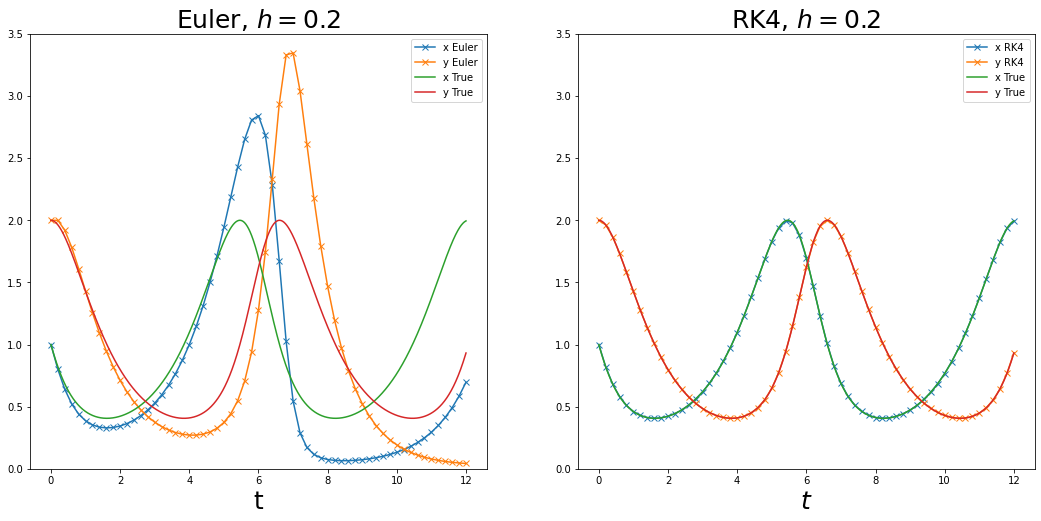

In [ ]:
h = 0.2

t_euler, v_euler = euler(LV, 1., 2., h, 60)
t_rk4, v_rk4 = rk4(LV, 1., 2., h, 60)
t_true, v_true = rk4(LV, 1., 2., 0.003, 4000)

plot_integrator(v_euler, v_rk4, t_euler, t_rk4, v_true, t_true, str(h))

### Phase space and phase portrait

It is useful to introduce the concept of phase space and phase portrait. Let us consider the differential equation of the simple pendulum of mass 1, length 1, and $g$ set to 1 for convenience:

$$
\ddot{\theta} + \sin{\theta} = 0.
$$

This is a second-order ODE, but it can be transformed in the following equivalent system of first-order ODEs by introducing the auxiliary variable $p_{\theta} = \dot{\theta}$:

$$
\begin{align}
&\dot{\theta} = p_{\theta} \\
&\dot{p_{\theta}} = \sin(\theta).
\end{align}
$$

$S^{1}\times\mathbb{R}$ is called the *phase space*, and $(\theta, p_{\theta}) \in S^{1}\times\mathbb{R}$ are called *phase space variables* ($\theta$ is periodic and therefore lives in $S^{1} = \{x \mod 2\pi | x \in \mathbb{R}\}$).

Given a solution $(\theta(t), p_{\theta}(t))$ we can represent it as a path in the phase space $S^{1}\times\mathbb{R}$:

In [ ]:
def pendulum(x, y):
  return np.array([y, -np.sin(x)])

def plot_phase_space(v):

    fig = plt.figure(figsize=(10,6))
    ax0 = fig.add_subplot(111)

    ax0.plot([p[0] for p in v], [p[1] for p in v])
  
    ax0.set_xlabel(r"$\theta$", fontsize=25)
    ax0.set_ylabel(r"$p_{\theta}$", fontsize=25)
    ax0.set_title("Phase space", fontsize=25)
    ax0.set_aspect('equal')

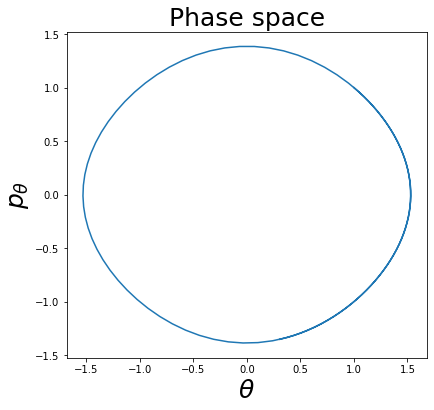

In [ ]:
t_pendulum, v_pendulum = rk4(pendulum, 1., 1., 0.1, 100)
plot_phase_space(v_pendulum)

A collection of paths in the phase space is called *phase space portrait* (or phase space diagram, or sometimes state space diagram), which can be thought as a geometric representation of the trajectories (here solutions of a system of ODEs) of a dynamical system in the phase plane. In a phase space portrait each initial conditions is represented by a different curve, or in the case of trivial solution (such as $(0, 0)$ in our example)  a point.

In [ ]:
def plot_phase_space_pendulum(V):

    fig = plt.figure(figsize=(18,8))
    ax0 = fig.add_subplot(121)
    for v in V:
      ax0.plot([p[0] for p in v], [p[1] for p in v], color='b')
  
    ax0.set_xlabel(r"$\theta$", fontsize=25)
    ax0.set_ylabel(r"$p_{\theta}$", fontsize=25)
    ax0.set_title("Phase space portrait", fontsize=25)
    ax0.set_aspect('equal')

def plot_phase_space_LV(V):

    fig = plt.figure(figsize=(18,8))
    ax0 = fig.add_subplot(121)
    for v in V:
      ax0.plot([p[0] for p in v], [p[1] for p in v], color='b')

    ax0.set_xlabel(r"$x$", fontsize=25)
    ax0.set_ylabel(r"$y$", fontsize=25)
    ax0.set_title("Phase space portrait", fontsize=25)

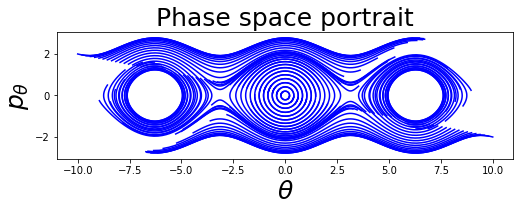

In [ ]:
IV = [[5*i, -i] for i in np.linspace(-2, 2, 99)] # initial values
paths = []
for iv in IV:
  t, v = rk4(pendulum, iv[0], iv[1], 0.1, 70)
  paths.append(v)

plot_phase_space_pendulum(paths)

We can plot the phase space of the Lotka-Volterra system.

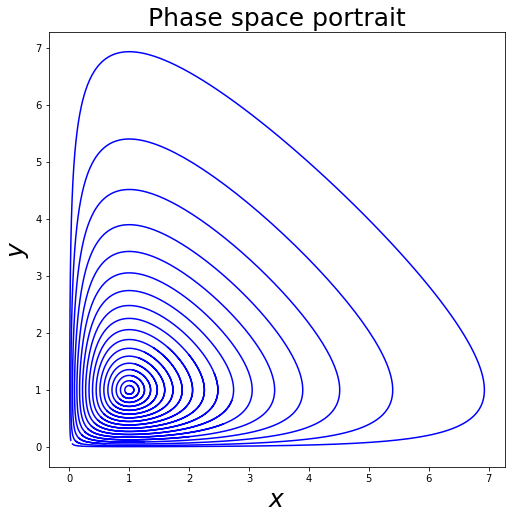

In [ ]:
IV = [[i, i] for i in np.linspace(0, 1, 20)] # initial values
paths = []
for iv in IV:
  t, v = rk4(LV, iv[0], iv[1], 0.01, 1000)
  paths.append(v)

plot_phase_space_LV(paths)

## 2. Neural ODEs

### Introduction

Given the intriguing properties of ODEs/solvers and the centuries-long
literature on the topic, it seems intriguing to combine them
with neural networks, i.e. try to model the transition function with a neural network. This combination could yield a powerful modelling tool, since neural networks are universal function approximators &mdash;they can in theory approximate any differentiable function to an arbitrary precision.

Remembering our earlier definitions, we have a first-order ODE:
$$\mathbf{\dot{y}}(t) = f(t, \mathbf{y}(t), \theta),\quad \mathbf{y}(t_0) = y_0,\quad f: \mathbb{R} \times \mathbb{R}^n \to \mathbb{R}^n $$

Our goal is to solve initial value problems (IVP), i.e. predict $\mathbf{y}(t_1)$ given $\mathbf{y}(t_0)$.

$$
\mathbf{y}(t_1) = \mathbf{y}(t_0) + \int_{t_0}^{t_1} f(\mathbf{y}(t), t, \theta)
\mathrm{d}t = \textrm{ODESolve}(\mathbf{y}(t_0), f, t_0, t_1, \theta)
$$

We can use a numerical solver to perform the forward pass and solve the IVP. If we use, for example, Euler's method, we have the following update rule:

$$
\mathbf{y}(t+h) = \mathbf{y}(t) + hf(\mathbf{y}(t), t)
$$

This formula looks almost identical to a ResNet block, and this was one of the main motivations for Neural ODEs.

### Comparison to Resnets

Many popular deep learning architectures like ResNets$^2$ update hidden
states by employing residual connections:

$$
  \mathbf{y}_{l+1} = \mathbf{y}_l + f(\mathbf{y}_l, \theta_l)
$$

where $f$ is a neural network with parameters $\theta_l$, and $\mathbf{y}_l$ and
$\mathbf{y}_{l+1}$ are the hidden states at subsequent layers, $l \in \{0,
\ldots, L\}$.

These updates can be seen as Euler discretizations of continuous transformations.

$$
\begin{align}
\mathbf{\dot{y}} &= f(\mathbf{y}, t, \theta)
\\
&\Bigg\downarrow \ \textrm{Euler Discretization}
\\
\mathbf{y}_{n+1} &= \mathbf{y}_n + h f(\mathbf{y}_n, t_n, \theta)
\end{align}
$$

Circling back to the continuous realm again, what happens in a residual network (with step sizes $h$) if we consider the continuous limit of each discrete layer in the network? In other words, what happens as we add more layers and take smaller
steps? The answer seems rather astounding: instead of having a discrete number of layers between the input and output domains, we allow the evolution of the hidden states to become continuous!

<center width="100%"><img src="https://github.com/phlippe/uvadlc_notebooks/blob/master/docs/tutorial_notebooks/DL2/Dynamical_systems/resnet_vs_odenet.png?raw=1" width="600px"></center>

(Figure credit: https://arxiv.org/abs/1806.07366)



$^2$ He, Kaiming, et al. "**Deep residual learning for image recognition**". CVPR 2016. https://arxiv.org/abs/1512.03385

### Backpropagation

We now have a way to perform the forward pass for our model. How do we
backpropagate and train the network, though?

One very straightforward way to perform backprop is to to back-propagate through
the solver. This would work since the forward pass operations are continuous and
differentiable. The problem, however, is that this incurs a
high-memory cost and we would need to save all intermediate activations of the
solver.

More importantly, though, our goal should be to try to approximate the exact derivative, rather than differentiating the approximation.

We want to optimize our scalar-valued loss function $L$ with respect to the model parameters $\theta$.

$$
L(\mathbf{x}(t_1)) = L\left(\mathbf{x}(t_0) + \int_{t_0}^{t_1} f(\mathbf{x}(t), t,
\theta)
\mathrm{d}t\right) = L\left(\textrm{ODESolve}(\mathbf{x}(t_0), f, t_0, t_1, \theta)\right)
$$

To optimize $L$ we require gradients with respect to $\theta$. 
The problem is to efficiently calculate $\frac{\mathrm{d}L(\mathbf{x}(t_1))}{\mathrm{d}\theta}$ without storing all the function activations from the forward pass.
**Adjoint method to the rescue**! The adjoint sensitivity method was developed in 1962 by Pontryagin et al.$^1$
It leverages the fact that the forward pass is the solution to an ODE, and computes gradients by solving a second, augmented ODE backwards in time.

Similar to standard neural networks, we start with determining how the gradient of the loss depends on the hidden state. This quantity is called the *adjoint* $\mathbf{a}(t) = \frac{\partial L}{\partial \mathbf{x}(t)}$.
It satisfies the following IVP:

$$
 \dot{\mathbf{a}}(t) = -\mathbf{a}(t)^{\top} \frac{\partial f(\mathbf{x}(t), t,
\theta)}{\partial \mathbf{x}}, \quad \mathbf{a}(t_1) = \frac{\partial L}{\partial \mathbf{x}(t_1)}.
$$

Thus, starting from the initial (remember we are running backwards) value $\mathbf{a}(t_1) = \frac{\partial L}{\partial \mathbf{x}(t_1)}$, we can compute $\mathbf{a}(t_0) = \frac{\partial L}{\partial \mathbf{x}(t_0)}$ by another call to an ODE solver.

Finally, computing the gradients with respect to the parameters $\theta$ requires evaluating a third integral,
which depends on both $\mathbf{x}(t)$ and $\mathbf{a}(t)$:

$$ \frac{\mathrm{d}L}{\mathrm{d}\theta} = -\int_{t_1}^{t_0} \mathbf{a}(t)^{\top}\frac{\partial f}{\partial \theta} \mathrm{d}t,
$$

So this method trades off computation for memory – in fact the memory requirement for this gradient calculation is $\mathcal{O}(1)$ with respect to the number of layers!

[Here](https://vaipatel.com/deriving-the-adjoint-equation-for-neural-odes-using-lagrange-multipliers/#:~:text=Luckily%2C%20a%20very%20well%2Dknown,to%20store%20intermediate%20function%20evaluations.) you can find a very good explanation of the following result based on Lagrange multipliers:

$^1$ Pontryagin, L.S. et al. "**The mathematical theory of optimal processes**". 1962

The full algorithm for *reverse mode auto-differentiation* is as follows:

<center width="100%"><img src="https://github.com/phlippe/uvadlc_notebooks/blob/master/docs/tutorial_notebooks/DL2/Dynamical_systems/neural_ode_algorithm.png?raw=1" width="800px"></center>

(Figure credit: https://arxiv.org/abs/1806.07366)

### Time to program some Neural ODEs

In this tutorial we will be working will Half Moons Dataset, a non-linearly separable, binary classification dataset.

This tutorial has been based on the excellent TorchDyn tutorials (https://github.com/DiffEqML/torchdyn), as well as the original TorchDiffEq examples (https://github.com/rtqichen/torchdiffeq). 

In [2]:
class MoonsDataset(Dataset):
    """Half Moons Classification Dataset
    
    Adapted from https://github.com/DiffEqML/torchdyn
    """
    def __init__(self, num_samples=400, noise_std=1e-4):
        self.num_samples = num_samples
        self.noise_std = noise_std
        self.X, self.y = self.generate_moons(num_samples, noise_std)

    @staticmethod
    def generate_moons(num_samples=100, noise_std=1e-4):
        """Creates a *moons* dataset of `num_samples` data points.
        :param num_samples: number of data points in the generated dataset
        :type num_samples: int
        :param noise_std: standard deviation of noise magnitude added to each data point
        :type noise_std: float
        """
        num_samples_out = num_samples // 2
        num_samples_in = num_samples - num_samples_out
        theta_out = np.linspace(0, np.pi, num_samples_out)
        theta_in = np.linspace(0, np.pi, num_samples_in)
        outer_circ_x = np.cos(theta_out)
        outer_circ_y = np.sin(theta_out)
        inner_circ_x = 1 - np.cos(theta_in)
        inner_circ_y = 1 - np.sin(theta_in) - 0.5

        X = np.vstack([np.append(outer_circ_x, inner_circ_x),
                       np.append(outer_circ_y, inner_circ_y)]).T
        y = np.hstack([np.zeros(num_samples_out), np.ones(num_samples_in)])

        if noise_std is not None:
            X += noise_std * np.random.rand(num_samples, 2)

        X = torch.Tensor(X)
        y = torch.LongTensor(y)
        return X, y

    def __len__(self):
        return self.num_samples

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [3]:
def plot_binary_classification_dataset(X, y, title=None):
    CLASS_COLORS = ['coral', 'darkviolet']
    fig, ax = plt.subplots(figsize=(10, 10))
    ax.scatter(X[:, 0], X[:, 1], color=[CLASS_COLORS[yi.int()] for yi in y], alpha=0.6)
    ax.set_aspect('equal')
    if title is not None:
        ax.set_title(title)

    return fig, ax

Let's create a sample dataset and visualize it.



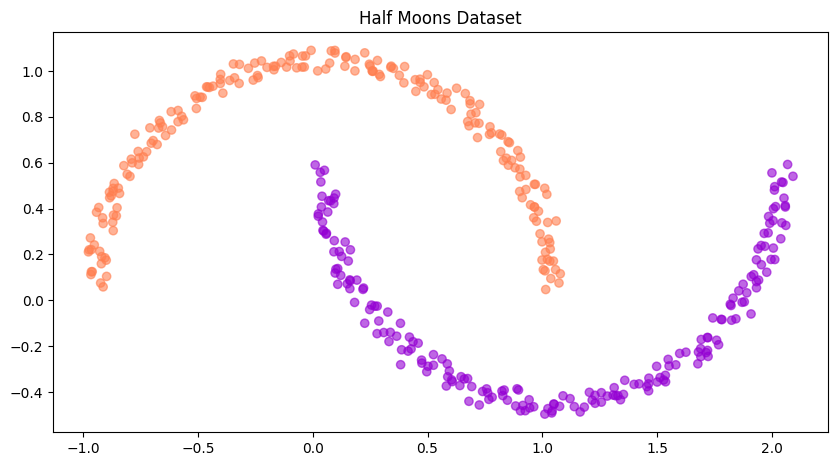

In [4]:
sample_dataset = MoonsDataset(num_samples=400, noise_std=1e-1)
fig, ax = plot_binary_classification_dataset(sample_dataset.X, sample_dataset.y, title='Half Moons Dataset')

Let's now create the train, validation, and test sets, with their corresponding data loaders. We will create a single big dataset and randomly split it in train, val, and test sets.

In [5]:
def split_dataset(dataset_size:int, split_percentages:List[float]) -> List[int]:
    split_sizes = [int(pi * dataset_size) for pi in split_percentages]
    split_sizes[0] += dataset_size - sum(split_sizes)
    return split_sizes


class ToyDataModule(pl.LightningDataModule):
    def __init__(self, dataset_size:int, split_percentages:Optional[float]=None):
        super().__init__()
        self.dataset_size = dataset_size
        if split_percentages is None:
            split_percentages = [0.8, 0.1, 0.1]
        self.split_sizes = split_dataset(self.dataset_size, split_percentages)

    def prepare_data(self):
        pass

    def setup(self, stage: Optional[str] = None):
        pass

    def train_dataloader(self):
        train_loader = torch.utils.data.DataLoader(self.train_set, batch_size=len(self.train_set), shuffle=True)
        return train_loader

    def val_dataloader(self):
        val_loader = torch.utils.data.DataLoader(self.val_set, batch_size=len(self.val_set), shuffle=False)
        return val_loader

    def test_dataloader(self):
        test_loader = torch.utils.data.DataLoader(self.test_set, batch_size=len(self.test_set), shuffle=False)
        return test_loader


class HalfMoonsDataModule(ToyDataModule):
    def __init__(self, dataset_size:int, split_percentages:Optional[float]=None):
        super().__init__(dataset_size, split_percentages=split_percentages)

    def setup(self, stage: Optional[str] = None):
        dataset = MoonsDataset(num_samples=self.dataset_size, noise_std=1e-1)
        self.train_set, self.val_set, self.test_set = torch.utils.data.random_split(dataset, self.split_sizes)

Now we define the core of our Neural ODE model.

In [6]:
class _ODEFunc(nn.Module):
    def __init__(self, module, autonomous=True):
        super().__init__()
        self.module = module
        self.autonomous = autonomous

    def forward(self, t, x):
        if not self.autonomous:
            x = torch.cat([torch.ones_like(x[:, [0]]) * t, x], 1)
        return self.module(x)


class ODEBlock(nn.Module):
    def __init__(self, odefunc: nn.Module, solver: str = 'dopri5',
                 rtol: float = 1e-4, atol: float = 1e-4, adjoint: bool = True,
                 autonomous: bool = True):
        super().__init__()
        self.odefunc = _ODEFunc(odefunc, autonomous=autonomous)
        self.rtol = rtol
        self.atol = atol
        self.solver = solver
        self.use_adjoint = adjoint
        self.integration_time = torch.tensor([0, 1], dtype=torch.float32)  
    
    @property
    def ode_method(self):
        return torchdiffeq.odeint_adjoint if self.use_adjoint else torchdiffeq.odeint

    def forward(self, x: torch.Tensor, adjoint: bool = True, integration_time=None):
        integration_time = self.integration_time if integration_time is None else integration_time
        integration_time = integration_time.to(x.device)
        ode_method =  torchdiffeq.odeint_adjoint if adjoint else torchdiffeq.odeint
        out = ode_method(
            self.odefunc, x, integration_time, rtol=self.rtol,
            atol=self.atol, method=self.solver)
        return out

We will wrap everything together in a **LightningModule**.

In [7]:
class Learner(pl.LightningModule):
    def __init__(self, model:nn.Module, t_span:torch.Tensor, learning_rate:float=5e-3):
        super().__init__()
        self.model = model
        self.t_span = t_span
        self.learning_rate = learning_rate
        self.accuracy = Accuracy(task = 'multiclass', num_classes=2)
    
    def forward(self, x):
        return self.model(x)

    def inference(self, x, time_span):
        return self.model(x, adjoint=False, integration_time=time_span)

    def inference_no_projection(self, x, time_span):
        return self.model.forward_no_projection(x, adjoint=False, integration_time=time_span)
   
    def training_step(self, batch, batch_idx):
        x, y = batch      
        y_pred = self(x)
        y_pred = y_pred[-1]  # select last point of solution trajectory
        loss = nn.CrossEntropyLoss()(y_pred, y)
        self.log('train_loss', loss, prog_bar=True, logger=True)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch      
        y_pred = self(x)
        y_pred = y_pred[-1]  # select last point of solution trajectory
        loss = nn.CrossEntropyLoss()(y_pred, y)
        self.log('val_loss', loss, prog_bar=True, logger=True)
        acc = self.accuracy(y_pred.softmax(dim=-1), y)
        self.log('val_accuracy', acc, prog_bar=True, logger=True)
        return loss

    def test_step(self, batch, batch_idx):
        x, y = batch      
        y_pred = self(x)
        y_pred = y_pred[-1]  # select last point of solution trajectory
        loss = nn.CrossEntropyLoss()(y_pred, y)
        self.log('test_loss', loss, prog_bar=True, logger=True)
        acc = self.accuracy(y_pred.softmax(dim=-1), y)
        self.log('test_accuracy', acc, prog_bar=True, logger=True)
        return loss

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.model.parameters(), lr=self.learning_rate)
        return optimizer

Finally, it is time to actually define a Neural ODE and train it. 
We will use a simple 2-layer MLP with a *tanh* activation and 64 hidden dimensions. We will train the model using the adjoint method for backpropagation.

A quick note on the architectural choices for our model. As mentioned in the first part of this tutorial, the **Picard-Lindel&ouml;f theorem** (Coddington and Levinson, 1955) states that the solution to an initial value problem **exists and is
unique** if the differential equation is _uniformly Lipschitz continuous_ in $\mathbf{z}$ and _continuous_ in $t$. It turns out that this
theorem holds for our model if the neural network has finite weights and uses Lipshitz nonlinearities, such as tanh or relu. However, not all tools are our deep learning arsenal is Lipshitz. For example, as shown in [**The Lipschitz Constant of Self-Attention**](https://arxiv.org/abs/2006.04710) by Hyunjik Kim et al., standard self-attention is ___not___ Lipshitz. The authors propose alternative forms of self-attention that are Lipshitz.

In [21]:
adjoint = True
data_module = HalfMoonsDataModule(1000)
t_span = torch.linspace(0, 1, 2)

def test_k(k):
  f = nn.Sequential(
    nn.Linear(2, k),
    nn.Tanh(),
    nn.Linear(k, 2))
  return f




for k in range(4,18,2):
  model = ODEBlock(test_k(k), adjoint=adjoint)
  learner = Learner(model, t_span)

  trainer = pl.Trainer(
      max_epochs=200,
      accelerator="gpu" if torch.cuda.is_available() else "cpu",
      devices=1,
      callbacks=[
          pl.callbacks.ModelCheckpoint(mode="max", monitor="val_accuracy"),
          pl.callbacks.RichProgressBar(),
      ],
      log_every_n_steps=1,
  )
  trainer.fit(learner, datamodule=data_module)
  val_result = trainer.validate(learner, datamodule=data_module, verbose=True)
  test_result = trainer.test(learner, datamodule=data_module, verbose=True)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


┏━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┓
┃   ┃ Name     ┃ Type               ┃ Params ┃
┡━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━┩
│ 0 │ model    │ ODEBlock           │     22 │
│ 1 │ accuracy │ MulticlassAccuracy │      0 │
└───┴──────────┴────────────────────┴────────┘

Trainable params: 22                                                                                               
Non-trainable params: 0                                                                                            
Total params: 22                                                                                                   
Total estimated model params size (MB): 0

/home/yanis/.local/lib/python3.8/site-packages/pytorch_lightning/trainer/call.py:54: UserWarning: Detected 
KeyboardInterrupt, attempting graceful shutdown...
  rank_zero_warn("Detected KeyboardInterrupt, attempting graceful shutdown...")

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       val_accuracy        │    0.6100000143051147     │
│         val_loss          │    0.6316128373146057     │
└───────────────────────────┴───────────────────────────┘

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test_accuracy       │    0.5699999928474426     │
│         test_loss         │    0.6316606402397156     │
└───────────────────────────┴───────────────────────────┘

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


┏━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┓
┃   ┃ Name     ┃ Type               ┃ Params ┃
┡━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━┩
│ 0 │ model    │ ODEBlock           │     32 │
│ 1 │ accuracy │ MulticlassAccuracy │      0 │
└───┴──────────┴────────────────────┴────────┘

Trainable params: 32                                                                                               
Non-trainable params: 0                                                                                            
Total params: 32                                                                                                   
Total estimated model params size (MB): 0

Excellent! It seems that in less that 200 epochs we have achieved perfect validation accuracy. Let's now use the trained model to run inference and visualize the trajectories using a dense time span of 100 timesteps.

In [8]:
adjoint = True
data_module = HalfMoonsDataModule(1000)
t_span = torch.linspace(0, 1, 2)


f = nn.Sequential(
    nn.Linear(2, 2),
    nn.Tanh(),
    nn.Linear(2, 2))




model = ODEBlock(f, adjoint=adjoint)
learner = Learner(model, t_span)

trainer = pl.Trainer(
      max_epochs=2000,
      accelerator="gpu" if torch.cuda.is_available() else "cpu",
      devices=1,
      callbacks=[
          pl.callbacks.ModelCheckpoint(mode="max", monitor="val_accuracy"),
          pl.callbacks.RichProgressBar(),
      ],
      log_every_n_steps=1,
  )
trainer.fit(learner, datamodule=data_module)
val_result = trainer.validate(learner, datamodule=data_module, verbose=True)
test_result = trainer.test(learner, datamodule=data_module, verbose=True)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/yanis/.local/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/logger_connector/logger_connector.py:67: UserWarning: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `pytorch_lightning` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default
  warning_cache.warn(


┏━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┓
┃   ┃ Name     ┃ Type               ┃ Params ┃
┡━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━┩
│ 0 │ model    │ ODEBlock           │     12 │
│ 1 │ accuracy │ MulticlassAccuracy │      0 │
└───┴──────────┴────────────────────┴────────┘

Trainable params: 12                                                                                               
Non-trainable params: 0                                                                                            
Total params: 12                                                                                                   
Total estimated model params size (MB): 0

Output()

/home/yanis/.local/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:430: 
PossibleUserWarning: The dataloader, val_dataloader, does not have many workers which may be a bottleneck. Consider
increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the 
`DataLoader` init to improve performance.
  rank_zero_warn(

/home/yanis/.local/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:430: 
PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. 
Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in
the `DataLoader` init to improve performance.
  rank_zero_warn(

`Trainer.fit` stopped: `max_epochs=2000` reached.


Output()

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       val_accuracy        │            1.0            │
│         val_loss          │   0.004518528934568167    │
└───────────────────────────┴───────────────────────────┘

Output()

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test_accuracy       │            1.0            │
│         test_loss         │   0.005345470272004604    │
└───────────────────────────┴───────────────────────────┘

/home/yanis/.local/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:430: PossibleUserWarning: The dataloader, test_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


In [9]:
@torch.no_grad()
def run_inference(learner, data_loader, time_span):
    learner.to(device)
    trajectories = []
    classes = []
    time_span = torch.from_numpy(time_span).to(device)
    for data, target in data_loader:
        data = data.to(device)
        traj = learner.inference(data, time_span).cpu().numpy()
        trajectories.append(traj)
        classes.extend(target.numpy())
    trajectories = np.concatenate(trajectories, 1)
    return trajectories, classes

time_span = np.linspace(0.0, 1.0, 100)
trajectories, classes = run_inference(learner, data_module.train_dataloader(), time_span)

colors = ['coral', 'darkviolet']
class_colors = [colors[ci] for ci in classes]

We will now define a few functions to visualize the learned trajectories, the state-space, and the learned vector field.


In [12]:
#@title You can omit reading this piece of code.

def plot_trajectories(time_span, trajectories, class_colors):
    fig = plt.figure(figsize=(12,6))
    ax0 = fig.add_subplot(121)
    ax1 = fig.add_subplot(122)
    for i in range(trajectories.shape[1]):
        ax0.plot(time_span, trajectories[:, i, 0], color=class_colors[i], alpha=0.1)
        ax1.plot(time_span, trajectories[:, i, 1], color=class_colors[i], alpha=0.1)

    ax0.set_xlabel(r"$t$ [Depth]")
    ax0.set_ylabel(r"$\mathbf{z}_0(t)$")
    ax0.set_title("Dimension 0")
    ax1.set_xlabel(r"$t$ [Depth]")
    ax1.set_ylabel(r"$\mathbf{z}_1(t)$")
    ax1.set_title("Dimension 1")


def plot_trajectories_3d(time_span, trajectories, class_colors):
    fig = plt.figure(figsize=(8, 8))
    ax = fig.add_subplot(111, projection='3d')
    for i in range(trajectories.shape[1]):
        ax.plot(trajectories[:, i, 0], trajectories[:, i, 1], time_span,
                color=class_colors[i], alpha=0.1)

    ax.set_title('3D Trajectories')
    ax.set_xlabel(r"$\mathbf{z}_0(t)$")
    ax.set_ylabel(r"$\mathbf{z}_1(t)$")
    ax.set_zlabel(r"$t$")


def plot_trajectories_animation(time_span, trajectories, colors, classes, lim=10.0):
    def animate_frame(t):
        ax.cla()
        ax.set_xlim(-lim, lim)
        ax.set_ylim(-lim, lim)
        ax.set_title('Trajectories')
        ax.set_xlabel(r"$\mathbf{z}_0(t)$")
        ax.set_ylabel(r"$\mathbf{z}_1(t)$")

        zero_classes = np.array(classes) == 0
        one_classes = np.array(classes) == 1

        scatter_zero = ax.plot(
            trajectories[t, zero_classes, 0], trajectories[t, zero_classes, 1],
            'o', color=colors[0], alpha=0.2+0.8*t/len(time_span))
        scatter_one = ax.plot(
            trajectories[t, one_classes, 0], trajectories[t, one_classes, 1],
            'o', color=colors[1], alpha=0.2+0.8*t/len(time_span))
        return scatter_zero, scatter_one

    fig = plt.figure(figsize=(8, 8))
    ax = fig.add_subplot(111)
    anim = FuncAnimation(fig, animate_frame, frames=len(time_span))
    plt.close(fig)
    return anim


def plot_augmented_trajectories_animation(time_span, trajectories, colors, classes, lim=10.0):
    def animate_frame(t):
        ax.cla()
        ax.set_xlim(-lim, lim)
        ax.set_ylim(-lim, lim)
        ax.set_zlim(-lim, lim)
        ax.set_title('Trajectories')
        ax.set_xlabel(r"$\mathbf{z}_0(t)$")
        ax.set_ylabel(r"$\mathbf{z}_1(t)$")
        ax.set_zlabel(r"$\mathbf{z}_2(t)$")

        zero_classes = np.array(classes) == 0
        one_classes = np.array(classes) == 1

        scatter_zero = ax.plot(
            trajectories[t, zero_classes, 0], trajectories[t, zero_classes, 1], trajectories[t, zero_classes, 2],
            'o', color=colors[0], alpha=0.2+0.8*t/len(time_span))
        scatter_one = ax.plot(
            trajectories[t, one_classes, 0], trajectories[t, one_classes, 1], trajectories[t, one_classes, 2],
            'o', color=colors[1], alpha=0.2+0.8*t/len(time_span))
        return scatter_zero, scatter_one

    fig = plt.figure(figsize=(8, 8))
    ax = fig.add_subplot(111, projection='3d')
    anim = FuncAnimation(fig, animate_frame, frames=len(time_span))
    plt.close(fig)
    return anim


def plot_state_space(trajectories, class_colors, ax=None):
    if ax is None:
        fig = plt.figure(figsize=(8, 8))
        ax = fig.add_subplot(111)

    for i in range(trajectories.shape[1]):
        ax.plot(trajectories[:, i, 0], trajectories[:, i, 1],
                color=class_colors[i], alpha=0.1)

    ax.set_title('State-Space Diagram')
    ax.set_xlabel(r"$x$")
    ax.set_ylabel(r"$y$")


def plot_augmented_state_space(trajectories, class_colors, ax=None):
    if ax is None:
        fig = plt.figure(figsize=(8, 8))
        ax = fig.add_subplot(111, projection='3d')

    for i in range(trajectories.shape[1]):
        ax.plot(trajectories[:, i, 0], trajectories[:, i, 1], trajectories[:, i, 2],
                color=class_colors[i], alpha=0.1)

    ax.set_title('State-Space Diagram')
    ax.set_xlabel(r"$x$")
    ax.set_ylabel(r"$y$")
    ax.set_zlabel(r"$z$")


def plot_static_vector_field(model, trajectory, N=50, device='cpu', ax=None):
    X, Y = np.mgrid[trajectory[..., 0].min():trajectory[..., 0].max():N*1j,
                    trajectory[..., 1].min():trajectory[..., 1].max():N*1j]
    X = X.T
    Y = Y.T
    P = np.vstack([X.ravel(), Y.ravel()]).T
    P = torch.Tensor(P).to(device)

    with torch.no_grad():
        vector_field = model.odefunc(0.0, P).cpu()
    vector_norm = vector_field.norm(dim=1).view(N, N).numpy()

    vector_field = vector_field.view(N, N, 2).numpy()

    if ax is None:
        fig = plt.figure(figsize=(8, 8))
        ax = fig.add_subplot(111)
    ax.contourf(X, Y, vector_norm, cmap='RdYlBu')
    ax.streamplot(X, Y, vector_field[:, :, 0], vector_field[:, :, 1], color='k')

    ax.set_xlim([X.min(), X.max()])
    ax.set_ylim([Y.min(), Y.max()])
    ax.set_xlabel(r"$x$")
    ax.set_ylabel(r"$y$")
    ax.set_title("Learned Vector Field")

Before we visualize the trajectories, let's plot the (training) data once again:

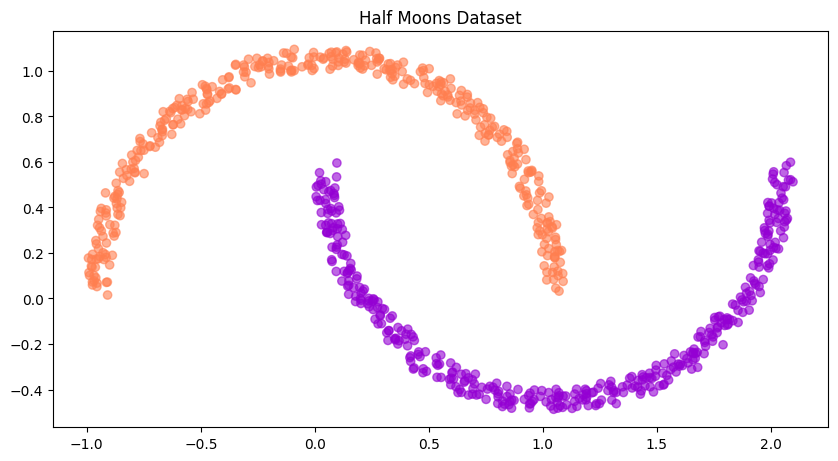

In [13]:
fig, ax = plot_binary_classification_dataset(*data_module.train_set[:], title='Half Moons Dataset')

Below we visualize the evolution for each of the 2 inputs dimensions as a function of time (depth):

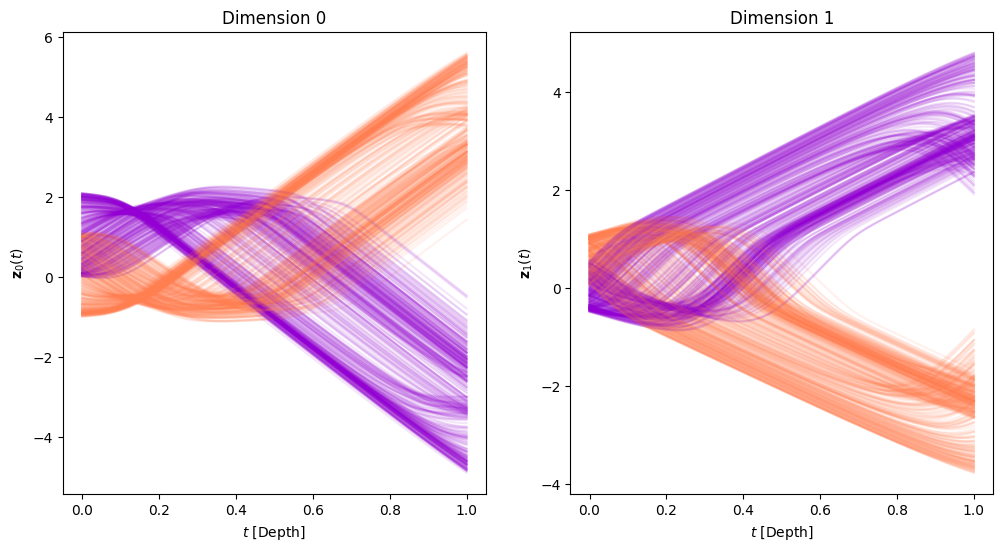

In [13]:
plot_trajectories(time_span, trajectories, class_colors)

And the same evolution combined in a single plot:

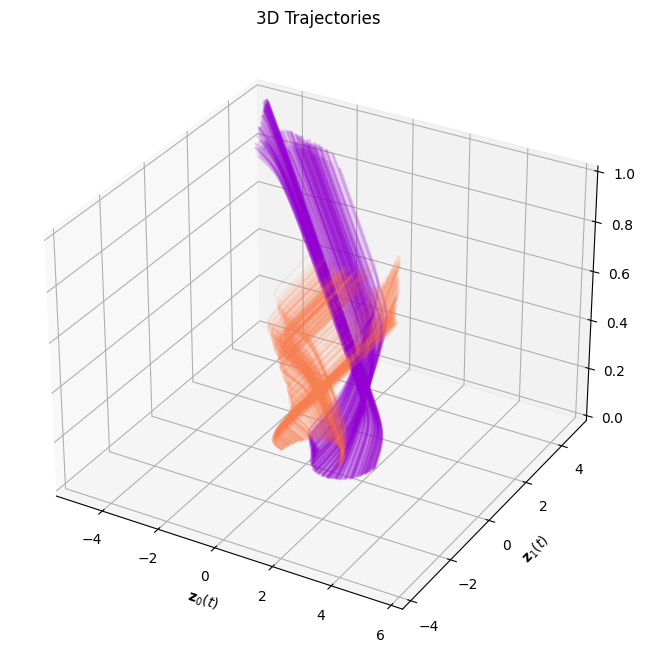

In [14]:
plot_trajectories_3d(time_span, trajectories, class_colors)

The 3D plot can be somewhat complicated to decipher. Thus, we also plot an animated version of the evolution. Each timestep of the animation is a slice on the temporal axis of the figure above.

In [15]:
anim = plot_trajectories_animation(time_span, trajectories, colors, classes, lim=8.0)
HTML(anim.to_html5_video())

Finally, let's visualize the state-space diagram and the learned vector field:

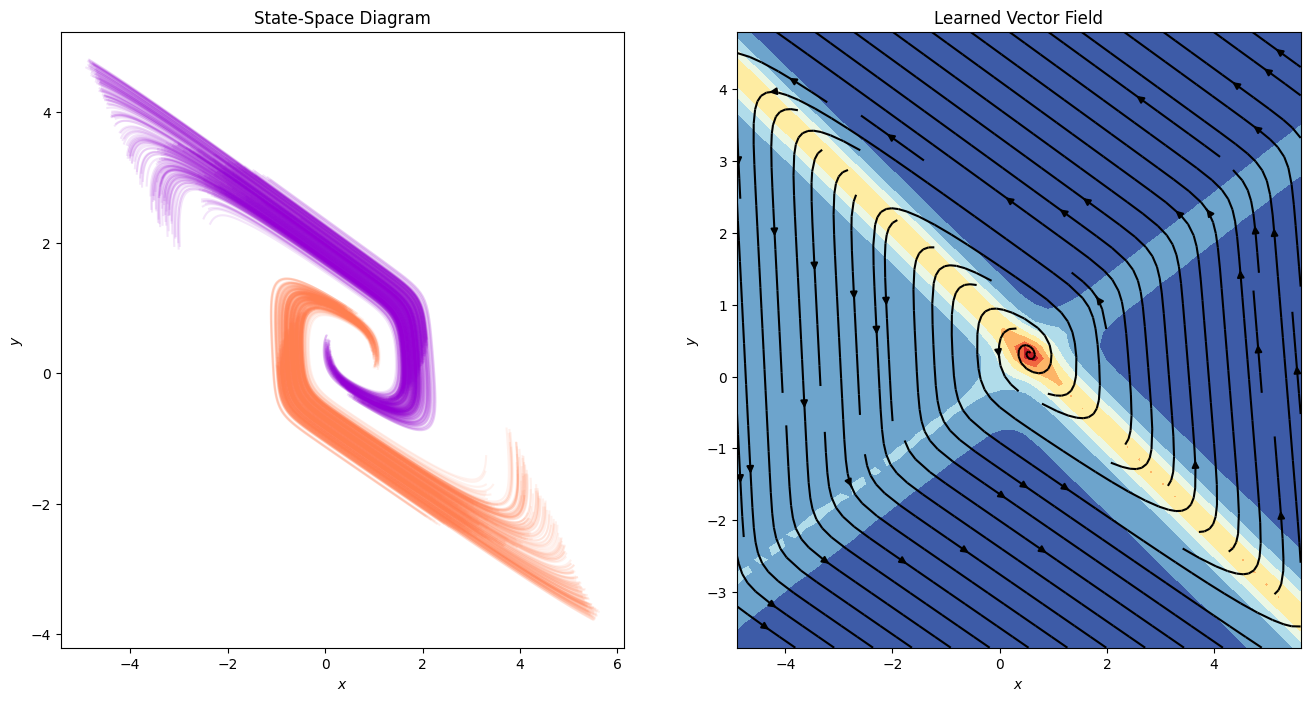

In [16]:
fig, ax = plt.subplots(1, 2, figsize=(16, 8))
plot_state_space(trajectories, class_colors, ax=ax[0])
plot_static_vector_field(model, trajectories, ax=ax[1], device=device)

### Neural ODEs can only describe homeomorphisms

It seems that the network can indeed do a very good job at separating data from these 2 classes. We will now move to different setting, which appears similar at first in terms of difficulty, but will turn out to be very hard, even impossible theoretically for Neural ODEs to solve in their basic form.

Neural ODEs describe homeomorphisms (flows). Inputs/hidden states/outputs have
the same dimensionality. They form non-intersecting trajectories.

Since Neural ODEs cannot model non-homeomorphisms, they cannot, for example, separate a 2d concentric annuli/circles dataset.

$$ 0 < r_1 < r_2 < r_3, \quad g: \mathbb{R}^2 \to \mathbb{R} $$

$$
\begin{cases}
  g(\mathbf{x}) = 0, & \lVert \mathbf{x}\rVert \leq r_1,\\
  g(\mathbf{x}) = 1, & r_2 \leq \lVert \mathbf{x}\rVert \leq r_3
\end{cases}
$$

<center width="100%"><img src="https://github.com/phlippe/uvadlc_notebooks/blob/master/docs/tutorial_notebooks/DL2/Dynamical_systems/2d_circles_dataset.png?raw=1" width="200px"></center>

(Figure credit: [Emilien Dupont et al.](https://arxiv.org/abs/1904.01681))

Neural ODEs cannot represent that function, the features of NODEs preserve the topology of the input space.
NODEs can only continuously deform the input space, and cannot, for
example, tear a connected region apart.

In practice, however, Neural ODEs are not trained on continuous regions of space, they are rather trained on a finite number of
data points. This means that NODEs can "cheat" and stretch space, squeezing through the gaps between data points.
This can lead to ill-posed ODE problems that are numerically expensive to solve.

Let's see this effect in practice. First, we will define a similar dataset that comprises 2 2D concentric circles.

In [ ]:
def rand_sphere(num_samples:int, dim:int, radius:float) -> torch.Tensor:
    """Uniform sample from a `dim`-dimensional sphere of radius `radius`
    :param num_samples: number of points to sample
    :type num_samples: int
    :param dim: dimension of the hyper-sphere
    :type dim: int
    :param radius: radius of the hyper-sphere
    :type radius: float
    """
    v = torch.randn(num_samples, dim)
    points = radius * F.normalize(v, dim=-1)
    return points


class ConcentricCircles(Dataset):
    """Concentric Circles Classification Dataset
    
    Adapted from https://github.com/DiffEqML/torchdyn
    """
    def __init__(self, num_samples=100, noise_std=1e-4, inner_radius=0.5,
                 outer_radius=1.0):
        self.num_samples = num_samples
        self.noise_std = noise_std
        self.X, self.y = self.generate_concentric_circles(num_samples, noise_std)

    @staticmethod
    def generate_concentric_circles(num_samples:int=100, noise_std:float=1e-4,
                                    inner_radius:float=0.5, outer_radius:int=1.0):
        """Creates a *concentric circles* dataset of `num_samples` datasets points.
        :param num_samples: number of datasets points in the generated dataset
        :type num_samples: int
        :param noise_std: standard deviation of noise magnitude added to each datasets point
        :type noise_std: float
        :param inner_radius: radius of the inner circle
        :type inner_radius: float
        :param outer_radius: radius of the outer circle
        :type outer_radius: float
        """
        y = torch.zeros(num_samples, dtype=torch.long)
        y[:num_samples // 2] = 1

        X = torch.zeros((num_samples, 2))
        X[:num_samples // 2] = rand_sphere(num_samples // 2, 2, inner_radius)
        X[num_samples // 2:] = rand_sphere(num_samples - num_samples // 2, 2, outer_radius)
        X += noise_std * torch.randn((num_samples, 2))

        return X, y

    def __len__(self):
        return self.num_samples

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

class ConcentricCirclesDataModule(ToyDataModule):
    def __init__(self, dataset_size:int, split_percentages:Optional[float]=None):
        super().__init__(dataset_size, split_percentages=split_percentages)
    
    def setup(self, stage: Optional[str] = None):
        dataset = ConcentricCircles(num_samples=self.dataset_size, noise_std=5e-2)
        self.train_set, self.val_set, self.test_set = torch.utils.data.random_split(dataset, self.split_sizes)

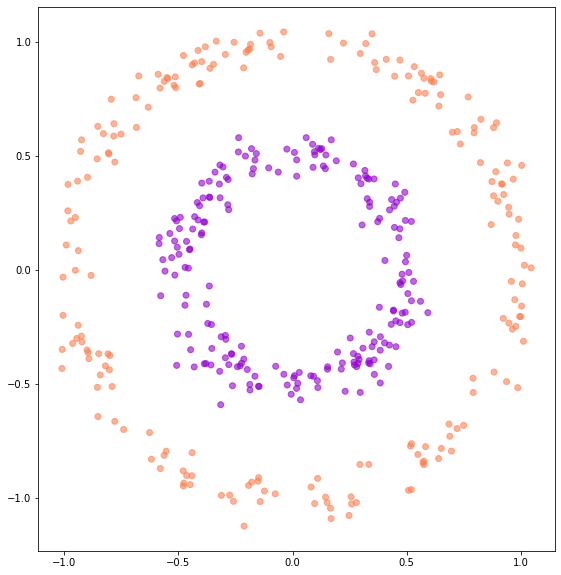

In [ ]:
sample_circles_set = ConcentricCircles(num_samples=401, noise_std=5e-2)
fig, ax = plot_binary_classification_dataset(*sample_circles_set[:])

We will now train a Neural ODE on this dataset. We will use a 3-layer MLP with ReLU activations and 64 hidden dimensions.

In [ ]:
circles_data_module = ConcentricCirclesDataModule(1000)

adjoint = True
t_span = torch.linspace(0, 1, 2)
f = nn.Sequential(nn.Linear(2, 64), nn.Tanh(), nn.Linear(64, 64), nn.Tanh(), nn.Linear(64, 2))
model = ODEBlock(f, adjoint=adjoint)
learner = Learner(model, t_span)

trainer = pl.Trainer(
    max_epochs=300,
    accelerator="gpu" if torch.cuda.is_available() else "cpu",
    devices=1,
    callbacks=[
        pl.callbacks.ModelCheckpoint(mode="max", monitor="val_accuracy"),
        pl.callbacks.RichProgressBar(),
    ],
    log_every_n_steps=1,
)

trainer.fit(learner, datamodule=circles_data_module)
val_result = trainer.validate(learner, datamodule=circles_data_module, verbose=True)
test_result = trainer.test(learner, datamodule=circles_data_module, verbose=True)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


┏━━━┳━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━┓
┃   ┃ Name     ┃ Type     ┃ Params ┃
┡━━━╇━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━┩
│ 0 │ model    │ ODEBlock │  4.5 K │
│ 1 │ accuracy │ Accuracy │      0 │
└───┴──────────┴──────────┴────────┘

Trainable params: 4.5 K                                                                      
Non-trainable params: 0                                                                      
Total params: 4.5 K                                                                          
Total estimated model params size (MB): 0

Output()

Output()

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       val_accuracy        │    0.9900000095367432     │
│         val_loss          │   0.042514488101005554    │
└───────────────────────────┴───────────────────────────┘

Output()

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test_accuracy       │    0.9900000095367432     │
│         test_loss         │   0.037914443761110306    │
└───────────────────────────┴───────────────────────────┘

Interestingly, the model can achieve perfect accuracy, even though in theory it cannot separate the 2 classes. Let's visualize the trajectories and see how this can be the case. SImilar to the previous experiment, we will first run inference and save the trajectories using a dense time span.

In [ ]:
num_timesteps = 100
time_span = np.linspace(0.0, 1.0, num_timesteps)
trajectories, classes = run_inference(learner, circles_data_module.train_dataloader(), time_span)

colors = ['coral', 'darkviolet']
class_colors = [colors[ci] for ci in classes]

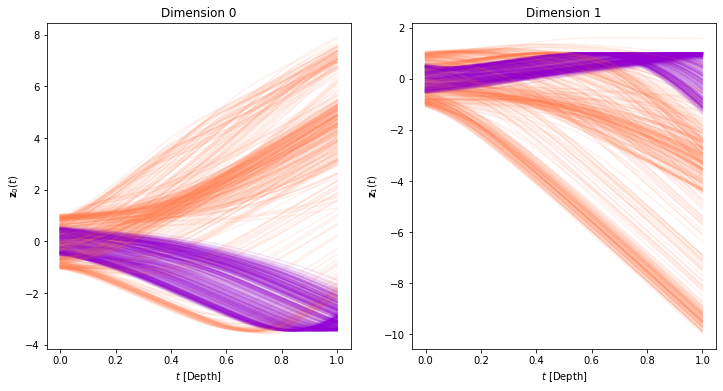

In [ ]:
plot_trajectories(time_span, trajectories, class_colors)

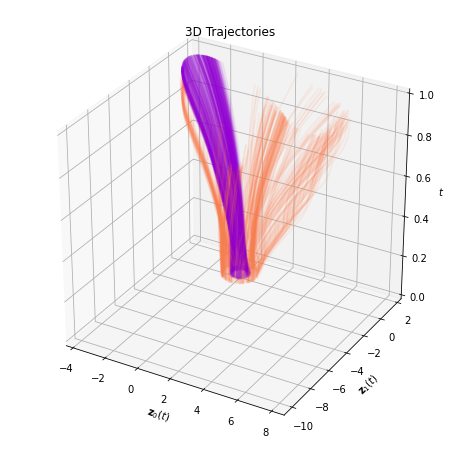

In [ ]:
plot_trajectories_3d(time_span, trajectories, class_colors)

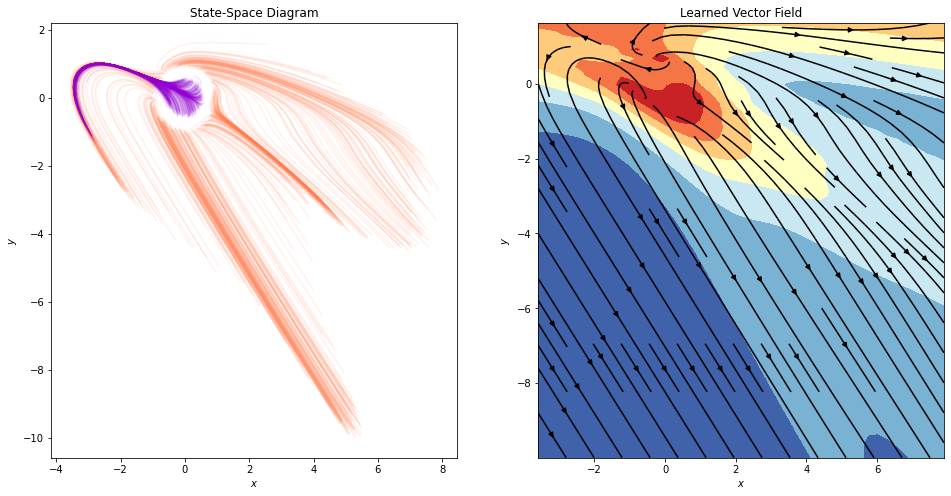

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(16, 8))
plot_state_space(trajectories, class_colors, ax=ax[0])
plot_static_vector_field(model, trajectories, ax=ax[1], device=device)

It is not clear neither from the trajectories, nor from the state-space, how the model manages to separate the data. Let's use an animated visualization of the evolution once again.

In [ ]:
anim = plot_trajectories_animation(time_span, trajectories, colors, classes, lim=12.0)
HTML(anim.to_html5_video())

The animation clearly shows that the model is cheating by stretching a part of space so much that data points from the inner circle can flow that region. Even though this offers perfect accuracy in this dataset, it comes at the expense of generalization capabilities, and increased train and inference time, since the network has to run many more function evaluations to achieve these results.

### Augmented Neural ODEs

These issues were first observed (in the context of Neural ODEs) by Emilien Dupont et al., in their work on [**Augmented Neural ODEs**](https://arxiv.org/abs/1904.01681). The authors propose a very simple yet elegant solution to the problem: they augment the space on which they learn and solve the ODE, from 
$\mathbb{R}^d$ to $\mathbb{R}^{d+p}$.
The initial state $\mathbf{x}$ is augmented with additional dimensions $\mathbf{a}$ that are initialized with 0.

The augmented ODE problem is formulated as:
$$
\begin{bmatrix}
\mathbf{\dot{h}}(t)
\\
\mathbf{\dot{a}}(t)
\end{bmatrix}
=
\mathbf{f}
\left(
\begin{bmatrix}
\mathbf{\dot{h}}(t)
\\
\mathbf{\dot{a}}(t)
\end{bmatrix}    
\right),
\ \ \ 
\begin{bmatrix}
\mathbf{h}(0)
\\
\mathbf{a}(0)
\end{bmatrix}
=
\begin{bmatrix}
\mathbf{x}
\\
\mathbf{0}
\end{bmatrix}   
$$

The final predictions in the original space are achieved via a final network that transforms the output augmented states:

$$
\mathbf{\hat{y}} =
\mathbf{g}
\left(
\begin{bmatrix}
\mathbf{h}(T)
\\
\mathbf{a}(T)
\end{bmatrix}
\right),
$$

where $\mathbf{g}$ can be an *MLP* or even a simple *linear* layer.

We will now define a simple Augmenter module, and a Neural ODE wrapper that incorporates the Augmenter and the output network.

In [ ]:
class ZeroAugmenter(nn.Module):
    def __init__(self, axis=1, num_dims=1):
        super().__init__()
        self.axis = axis
        self.num_dims = num_dims
    
    def forward(self, x):
        aug_dims = list(x.shape)
        aug_dims[self.axis] = self.num_dims
        augmentation = torch.zeros(aug_dims, device=x.device, dtype=x.dtype)
        return torch.cat([x, augmentation], dim=self.axis)


class AugmentedNODEWrapper(nn.Module):
    def __init__(self, augmenter, neural_ode, out_net):
        super().__init__()
        self.augmenter = augmenter
        self.neural_ode = neural_ode
        self.out_net = out_net
    
    def forward(self, x: torch.Tensor, adjoint: bool = True, integration_time=None):
        x = self.augmenter(x)
        x = self.neural_ode(x, adjoint, integration_time)
        x = self.out_net(x)
        return x
    
    def forward_no_projection(self, x: torch.Tensor, adjoint: bool = True, integration_time=None):
        x = self.augmenter(x)
        x = self.neural_ode(x, adjoint, integration_time)
        return x

We will continue with the same dataset as before, namely the 2D concentric circles. We will use a single augmentation dimension and a simple linear layer $\mathbf{g}: \mathbb{R}^3 \to \mathbb{R}^2$.

In [ ]:
circles_data_module = ConcentricCirclesDataModule(1000)

adjoint = True
t_span = torch.linspace(0, 1, 2)
augmentation_dims = 1
f = nn.Sequential(nn.Linear(2+augmentation_dims, 64), nn.Tanh(), nn.Linear(64, 2+augmentation_dims))
no_augm_model = ODEBlock(f, adjoint=adjoint)
model = AugmentedNODEWrapper(ZeroAugmenter(num_dims=augmentation_dims), no_augm_model, nn.Linear(2+augmentation_dims, 2))
learner = Learner(model, t_span)

trainer = pl.Trainer(
    max_epochs=100,
    accelerator="gpu" if torch.cuda.is_available() else "cpu",
    devices=1,
    callbacks=[
        pl.callbacks.ModelCheckpoint(mode="max", monitor="val_accuracy"),
        pl.callbacks.RichProgressBar(),
    ],
    log_every_n_steps=1,
)

trainer.fit(learner, datamodule=circles_data_module)
val_result = trainer.validate(learner, datamodule=circles_data_module, verbose=True)
test_result = trainer.test(learner, datamodule=circles_data_module, verbose=True)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


┏━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┓
┃   ┃ Name     ┃ Type                 ┃ Params ┃
┡━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━┩
│ 0 │ model    │ AugmentedNODEWrapper │    459 │
│ 1 │ accuracy │ Accuracy             │      0 │
└───┴──────────┴──────────────────────┴────────┘

Trainable params: 459                                                                        
Non-trainable params: 0                                                                      
Total params: 459                                                                            
Total estimated model params size (MB): 0

Output()

Output()

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       val_accuracy        │            1.0            │
│         val_loss          │   7.259416634042282e-06   │
└───────────────────────────┴───────────────────────────┘

Output()

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test_accuracy       │            1.0            │
│         test_loss         │   5.69325675314758e-06    │
└───────────────────────────┴───────────────────────────┘

Even with a single augmentation dimension, the model can very quickly achieve perfect accuracy in the validation set. Let us now compute and visualize the trajectories, in order to gain a better understanding of what is actually going on.

In [ ]:
num_timesteps = 100
time_span = np.linspace(0.0, 1.0, num_timesteps)
trajectories, classes = run_inference(learner, circles_data_module.train_dataloader(), time_span)

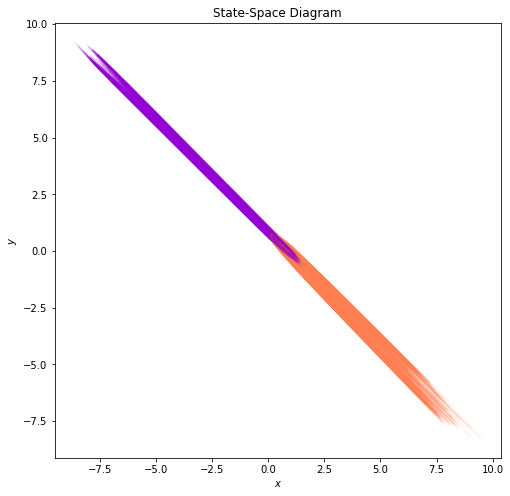

In [ ]:
plot_state_space(trajectories, class_colors)

In [ ]:
anim = plot_trajectories_animation(time_span, trajectories, colors, classes, lim=8.0)
HTML(anim.to_html5_video())

From the 2D plots, it is not exactly clear how the model can achieve perfect separation. Thus, in what follows, we will visualize the trajectories and the state-space in the augmented 3D space. 

In [ ]:
@torch.no_grad()
def run_inference_no_projection(learner, data_loader, time_span):
    trajectories = []
    classes = []
    learner = learner.to(device)
    time_span = torch.from_numpy(time_span).to(device)
    for data, target in data_loader:
        data = data.to(device)
        traj = learner.inference_no_projection(data, time_span).cpu().numpy()
        trajectories.append(traj)
        classes.extend(target.numpy())
    trajectories = np.concatenate(trajectories, 1)
    return trajectories, classes

num_timesteps = 100
time_span = np.linspace(0.0, 1.0, num_timesteps)
trajectories, classes = run_inference_no_projection(learner, circles_data_module.train_dataloader(), time_span)
colors = ['coral', 'darkviolet']
class_colors = [colors[ci] for ci in classes]

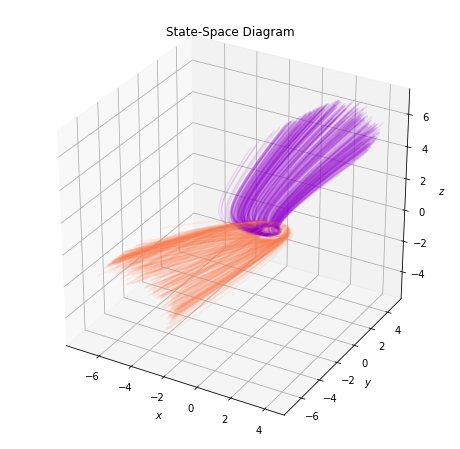

In [ ]:
plot_augmented_state_space(trajectories, class_colors)

In [ ]:
anim = plot_augmented_trajectories_animation(time_span, trajectories, colors, classes, lim=8.0)
HTML(anim.to_html5_video())

## Further Reading

Neural ODEs is an exciting topic that has received a lot of attention in the past few years, ever since their introduction in Neurips 2018. Some of many many work in this field include:

- Neural Stochastic Differential Equations (Neural SDEs)
- Neural Controlled Differential Equations (Neural CDEs)
- Graph ODEs
- Hamiltonial Neural Networks
- Lagrangian Neural Networks

If you want to see a quick overview of different works in the field, [Michael Poli](https://zymrael.github.io/) maintains the excellent [Awesome Neural ODE](https://github.com/Zymrael/awesome-neural-ode),
a collection of resources regarding the interplay between neural differential equations, dynamical systems, deep learning, control, numerical methods and scientific machine learning.

[Torchdyn](https://github.com/DiffEqML/torchdyn) is an excellent library for Neural Differential Equations.

[Implicit Layers](https://implicit-layers-tutorial.org/) is a list of tutorials 
on implicit functions and automatic differentiation, Neural ODEs, and Deep Equilibrium Models.

[Here](https://jontysinai.github.io/jekyll/update/2019/01/18/understanding-neural-odes.html) is an excellent blogpost on ODEs and Neural ODEs.

[Patrick Kidger](https://kidger.site/)'s doctoral dissertation is an excellent textbook on [Neural Differential Equations](https://arxiv.org/abs/2202.02435).

## References

[1] Chen, Ricky T. Q. et al. "**Neural ordinary differential equations**". _NeurIPS_ 2018. https://arxiv.org/abs/1806.07366

[2] Dupont, Emilien et al. "**Augmented Neural ODEs**". _NeurIPS_ 2019. https://arxiv.org/abs/1904.01681

[3] Pontryagin, L.S. et al. "**The mathematical theory of optimal processes**". 1962